In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../scripts/')

import os
os.environ["PATH"] += os.pathsep + r'\Users\Mattia\AppData\Local\Programs\MiKTeX 2.9\miktex\bin\x64'
print(os.getenv("PATH"))

from proj1_helpers import *
from implementations import *
from implementation_variants import *
from plots import *

SEED = 42
DATA_PATH = '../data/'

C:\Users\Mattia\anaconda3;C:\Users\Mattia\anaconda3\Library\mingw-w64\bin;C:\Users\Mattia\anaconda3\Library\usr\bin;C:\Users\Mattia\anaconda3\Library\bin;C:\Users\Mattia\anaconda3\Scripts;C:\Users\Mattia\anaconda3\bin;C:\Users\Mattia\anaconda3\condabin;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Windows\System32\OpenSSH;C:\Program Files\MATLAB\R2020a\bin;C:\Program Files\Git\cmd;C:\Program Files\Git\mingw64\bin;C:\Program Files\Git\usr\bin;C:\Users\Mattia\AppData\Local\Microsoft\WindowsApps;C:\Users\Mattia\AppData\Local\GitHubDesktop\bin;C:\Users\Mattia\AppData\Local\Programs\MiKTeX 2.9\miktex\bin\x64;\Users\Mattia\AppData\Local\Programs\MiKTeX 2.9\miktex\bin\x64


# 0 Load data

In [153]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train.set_index('Id')
df_train_x = df_train[list(filter(lambda c: c != 'Prediction', list(df_train)))]

FEATURE_NAMES = list(df_train_x)
FEATURE_NAMES=FEATURE_NAMES+[str(i) for i in range(180-len(FEATURE_NAMES))]

In [154]:
 # Load train data
y, x, ids = load_csv_data(path.join(DATA_PATH, 'train.csv'))

x=np.hstack((x,x**2,x**3,x**4,x**5,x**6))
print(x.shape)

# Split into train and evaluation set
(x_train, y_train), (x_eval, y_eval) = train_eval_split(y, x, split_ratio=.7, seed=1) #alternatives: CV or adding validation and testing

print(f' # train samples: {len(y_train)}\n # eval samples: {len(y_eval)}')

num_dim = x_train.shape[1]

(250000, 180)
 # train samples: 175000
 # eval samples: 75000


In [144]:
def generate_mask(features_to_remove):
    feat_idx = [FEATURE_NAMES.index(f) for f in features_to_remove]
    mask = np.ones(len(FEATURE_NAMES)).astype(bool)
    mask[feat_idx] = False
    
    return mask

In [155]:
LEAST_INFO = ['DER_mass_vis', 'DER_deltar_tau_lep','DER_pt_tot','PRI_tau_eta','PRI_tau_phi',
              'PRI_lep_pt','PRI_lep_eta','PRI_lep_phi','PRI_met','PRI_met_phi']

JET_NOT_DEFINED = ['DER_lep_eta_centrality', 'DER_prodeta_jet_jet', 'DER_mass_jet_jet', 'DER_deltaeta_jet_jet', 
                      'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_subleading_pt']

DER_FEATURES = list(filter(lambda c: 'DER' in c, list(FEATURE_NAMES)))

feature_masks = [generate_mask([]), generate_mask(LEAST_INFO)]

labels = ['Raw', 'MostInfo', 'ImputeJet', 'DeCorrelate']

In [146]:
def compare_features_visualisation(acc_train, acc_test, labels, model):
    arr_train = acc_train.flatten()
    arr_test = acc_test.flatten()

    arr_features = np.concatenate([np.repeat(labels, acc_train.shape[1]), np.repeat(labels, acc_train.shape[1])])
    arr_labels = np.concatenate([np.repeat('Train', len(arr_train)), np.repeat('Test', len(arr_test))])
    arr_acc = np.concatenate([arr_train, arr_test])

    plt_data = pd.DataFrame({'Feature Set':arr_features, 'Accuracy':arr_acc, 'Set':arr_labels})

    fig, ax = plt.subplots(figsize=(8,3.5))
    ax = sns.boxplot(x='Feature Set', y='Accuracy', hue='Set', data=plt_data)
    ax.set(ylabel='$\mathtt{Accuracy}$', title=f'{model}');
    
    return fig

# 1 Least-Squares

In [147]:
def run_least_squares(y_train, x_train, y_eval, x_eval, feature_mask):
    # Remove unwanted features
    x_train = x_train[:, feature_mask]
    x_eval = x_eval[:, feature_mask]
    
    # Standardise to training mean and s.d.
    x_train, mean_x, std_x = standardise(x_train)
    x_eval = standardise_to_fixed(x_eval, mean_x, std_x)
    
    # Run training
    w, loss = least_squares(y_train, x_train)
#     print(f'Training loss: {loss}')

    # Get training accuracy
    acc_tr  = eval_model(y_train, x_train, w, thresh=0)
#     print(f'Training accuracy: {acc_tr}')

    # Get accuracy on evaluation set
    acc_te = eval_model(y_eval, x_eval, w, thresh=0)
    print(f'Test Accuracy: {acc_te}')
    
    return w, loss, acc_tr, acc_te

Feature Set:  Raw
Test Accuracy: 0.7528457142857143
Test Accuracy: 0.7498742857142857
Test Accuracy: 0.75184
Test Accuracy: 0.75056
Feature Set:  MostInfo
Test Accuracy: 0.7528914285714285
Test Accuracy: 0.7499657142857142
Test Accuracy: 0.7531885714285714
Test Accuracy: 0.7516342857142857
Feature Set: Impute
Test Accuracy: 0.7530971428571429
Test Accuracy: 0.7447314285714286
Test Accuracy: 0.7535314285714285
Test Accuracy: 0.7479771428571429
Feature Set: Indicator
Test Accuracy: 0.7515657142857143
Test Accuracy: 0.7496
Test Accuracy: 0.7529371428571429
Test Accuracy: 0.7508114285714286


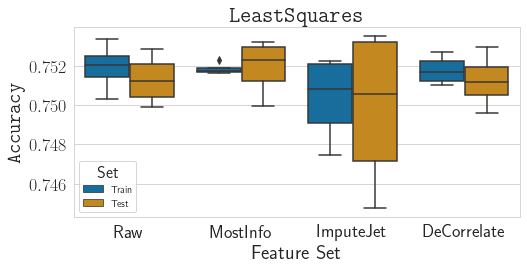

In [156]:
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(feature_masks)+2, k_fold), float)
acc_test = np.empty((len(feature_masks)+2, k_fold), float)
    
for i, features in enumerate(feature_masks):
    print('Feature Set: ', labels[i])
    k = 0
    for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Run evaluation
            w, loss, acc_tr, acc_te = run_least_squares(train_split[1], train_split[0], 
                                                        test_split[1], test_split[0], features)
            acc_train[i, k] = acc_tr
            acc_test[i, k] = acc_te
            
            k+=1
            
print('Feature Set: Impute')
col_index = [FEATURE_NAMES.index(i) for i in JET_NOT_DEFINED]
x_train_imp = x_train.copy()
x_train_imp[x_train_imp == -999] = -100

x_eval_imp = x_eval.copy()
x_eval_imp[x_eval_imp == -999] = -100

features = generate_mask([])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_least_squares(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-2, k] = acc_tr
        acc_test[-2, k] = acc_te

        k+=1
        
print('Feature Set: Indicator')
JET_NUM_IDX = FEATURE_NAMES.index('PRI_jet_num')

x_ind = (x_train[:, JET_NUM_IDX] > 1).astype(int)
# x_train_imp = np.delete(x_train, JET_NUM_IDX, axis=1)
x_train_imp = np.concatenate([x_train, np.expand_dims(x_ind, axis=1)], axis=1)

features = generate_mask(['DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'])
features = np.concatenate([features, [True]])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_least_squares(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-1, k] = acc_tr
        acc_test[-1, k] = acc_te

        k+=1
            
fig = compare_features_visualisation(acc_train, acc_test, labels, '$\mathtt{LeastSquares}$')
fig.savefig('../report/compare_features_ls.pdf', bbox_inches='tight')

# 2 Ridge Regresion

In [157]:
def run_ridge(y_train, x_train, y_eval, x_eval, feature_mask):
    # Remove unwanted features
    x_train = x_train[:, feature_mask]
    x_eval = x_eval[:, feature_mask]
    
    # Standardise to training mean and s.d.
    x_train, mean_x, std_x = standardise(x_train)
    x_eval = standardise_to_fixed(x_eval, mean_x, std_x)
    
    lambdas = np.logspace(-8, -1, 10)
    k_fold = 4

    # Hyperparameter optimisation
    acc_train = np.empty((len(lambdas), k_fold), float)
    acc_test = np.empty((len(lambdas), k_fold), float)

    for l, lambda_ in enumerate(lambdas):
        k = 0
        for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Train
            w, loss = ridge_regression(train_split[1], train_split[0], lambda_)
            acc_tr = eval_model(train_split[1], train_split[0], w)
            acc_train[l, k] = acc_tr

            # Test
            acc_te = eval_model(test_split[1], test_split[0], w)
            acc_test[l, k] = acc_te

            k += 1
#     fig = cross_validation_visualization(lambdas, 1-acc_train, 1-acc_test)

    avg_acc_test = np.mean(acc_test, axis=1)
    lambda_opt_ridge = lambdas[np.argmax(avg_acc_test)]

    print('Maximum test accuracy {} with lambda {}'.format(np.max(avg_acc_test), lambda_opt_ridge))
    
    # Run training
    w, loss = ridge_regression(y_train, x_train, lambda_opt_ridge)
#     print(f'Training loss: {loss_ridge}')

    acc_tr = eval_model(y_train, x_train, w)
#     print(f'Training accuracy: {acc}')

    acc_te = eval_model(y_eval, x_eval, w)
    print(f'Test accuracy: {acc_te}')
    
    
    return w, loss, acc_tr, acc_te
    


Feature Set Raw
Maximum test accuracy 0.7303425576008777 with lambda 0.0004641588833612782
Test accuracy: 0.7336
Maximum test accuracy 0.7291463488967451 with lambda 0.0027825594022071257
Test accuracy: 0.7288914285714285
Maximum test accuracy 0.7280720468121419 with lambda 0.0004641588833612782
Test accuracy: 0.7334857142857143
Maximum test accuracy 0.7400417530171889 with lambda 2.1544346900318865e-06
Test accuracy: 0.7415314285714286

Feature Set MostInfo
Maximum test accuracy 0.7306168474948189 with lambda 0.0004641588833612782
Test accuracy: 0.7337142857142858
Maximum test accuracy 0.7291996830427891 with lambda 0.0004641588833612782
Test accuracy: 0.7317257142857143
Maximum test accuracy 0.7280110935023771 with lambda 0.0027825594022071257
Test accuracy: 0.72944
Maximum test accuracy 0.7404912836767036 with lambda 2.1544346900318865e-06
Test accuracy: 0.7416457142857142

Feature Set: ImputeJet
Maximum test accuracy 0.7312416189199074 with lambda 0.0004641588833612782
Test accura

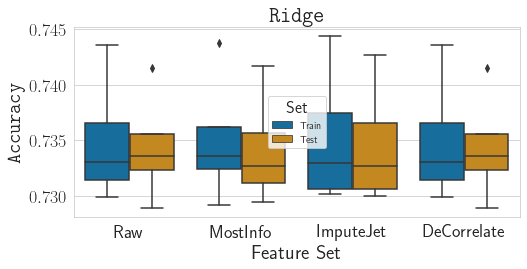

In [158]:
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(labels), k_fold), float)
acc_test = np.empty((len(labels), k_fold), float)
    
for i, features in enumerate(feature_masks):
    print('\nFeature Set', labels[i])
    k = 0
    for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Run evaluation
            w, loss, acc_tr, acc_te = run_ridge(train_split[1], train_split[0], 
                                                        test_split[1], test_split[0], features)
            acc_train[i, k] = acc_tr
            acc_test[i, k] = acc_te
            
            k+=1
            
print('\nFeature Set: ImputeJet')
col_index = [FEATURE_NAMES.index(i) for i in JET_NOT_DEFINED]
x_train_imp = x_train.copy()
x_train_imp[x_train_imp == -999] = -100

x_eval_imp = x_eval.copy()
x_eval_imp[x_eval_imp == -999] = -100

features = generate_mask([])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_ridge(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-2, k] = acc_tr
        acc_test[-2, k] = acc_te

        k+=1
        
print('\nFeature Set: DeCorrelate')
JET_NUM_IDX = FEATURE_NAMES.index('PRI_jet_num')

x_ind = (x_train[:, JET_NUM_IDX] > 1).astype(int)
# x_train_imp = np.delete(x_train, JET_NUM_IDX, axis=1)
x_train_imp = np.concatenate([x_train, np.expand_dims(x_ind, axis=1)], axis=1)

features = generate_mask(['DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'])
features = np.concatenate([features, [True]])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_ridge(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-1, k] = acc_tr
        acc_test[-1, k] = acc_te

        k+=1
            
fig = compare_features_visualisation(acc_train, acc_test, labels, '$\mathtt{Ridge}$')
fig.savefig('../report/compare_features_ridge.pdf', bbox_inches='tight')

# 3 Logistic Regression

In [95]:
def run_logistic(y_train, x_train, y_eval, x_eval, feature_mask):
    # Remove unwanted features
    x_train = x_train[:, feature_mask]
    x_eval = x_eval[:, feature_mask]
    
    # Standardise to training mean and s.d.
    x_train, mean_x, std_x = standardise(x_train)
    x_eval = standardise_to_fixed(x_eval, mean_x, std_x)

    tx_train = np.c_[np.ones(x_train.shape[0]), x_train]
    tx_eval = np.c_[np.ones(x_eval.shape[0]), x_eval]
    
    gamma = 0.01
    max_iters = 10000
    w_initial = np.ones(tx_train.shape[1])

    # Run gradient descent 
    w, loss = logistic_regression_mean(y_train, tx_train, w_initial, max_iters, gamma, threshold=1e-6)
#     print(f'Training loss: {loss_lr}')

    acc_tr = eval_model(y_train, tx_train, w, thresh=0.5)
#     print(f'Training accuracy: {acc}')

    acc_te = eval_model(y_eval, tx_eval, w, thresh=0.5)
    print(f'Testing accuracy: {acc_te}')
    
    return w, loss, acc_tr, acc_te

In [96]:
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(feature_masks)+2, k_fold), float)
acc_test = np.empty((len(feature_masks)+2, k_fold), float)
    
for i, features in enumerate(feature_masks):
    print('\nFeature Set: ', labels[i])
    k = 0
    for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Run evaluation
            w, loss, acc_tr, acc_te = run_logistic(train_split[1], train_split[0], 
                                                        test_split[1], test_split[0], features)
            acc_train[i, k] = acc_tr
            acc_test[i, k] = acc_te
            
            k+=1
            
print('\nFeature Set: Impute')
col_index = [FEATURE_NAMES.index(i) for i in JET_NOT_DEFINED]
x_train_imp = x_train.copy()
x_train_imp[x_train_imp == -999] = -100

x_eval_imp = x_eval.copy()
x_eval_imp[x_eval_imp == -999] = -100

features = generate_mask([])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_logistic(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-2, k] = acc_tr
        acc_test[-2, k] = acc_te

        k+=1
        
print('\nFeature Set: Indicator')
JET_NUM_IDX = FEATURE_NAMES.index('PRI_jet_num')

x_ind = (x_train[:, JET_NUM_IDX] > 1).astype(int)
# x_train_imp = np.delete(x_train, JET_NUM_IDX, axis=1)
x_train_imp = np.concatenate([x_train, np.expand_dims(x_ind, axis=1)], axis=1)

features = generate_mask(['DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'])
features = np.concatenate([features, [True]])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_logistic(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-1, k] = acc_tr
        acc_test[-1, k] = acc_te

        k+=1
            
fig = compare_features_visualisation(acc_train, acc_test, labels, '$\mathtt{LogReg}$')
fig.savefig('../report/compare_features_logreg.pdf', bbox_inches='tight')


Feature Set:  Raw


../scripts\costs.py:49: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(z)) - y * z)
../scripts\implementation_variants.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:


KeyboardInterrupt: 

# -------------

# Compare model performance on best performing feature set 

##### Data Processing

In [97]:
JET_NUM_IDX = FEATURE_NAMES.index('PRI_jet_num')

def feature_transform(x):
    x_ind = (x[:, JET_NUM_IDX] > 1).astype(int)
    x = np.concatenate([x, np.expand_dims(x_ind, axis=1)], axis=1)

    features = generate_mask(['DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'])
    features = np.concatenate([features, [True]])

    x = x[:, features]
    
    return x

fx_train = feature_transform(x_train)
fx_eval = feature_transform(x_eval)

fx_train, mu_x, sigma_x = standardise(fx_train)
fx_eval = standardise_to_fixed(fx_eval, mu_x, sigma_x)

tx_train = np.c_[np.ones(fx_train.shape[0]), fx_train]
tx_eval = np.c_[np.ones(fx_eval.shape[0]), fx_eval]

fx_train.shape

(175000, 59)

##### Baseline

In [98]:
# Get baseline frequency of the two classes in training data
prior_probs = [sum(y_train == 1)/len(y_train), sum(y_train == 0)/len(y_train)]

# Test error on evaluation set
y_eval_pred = np.random.choice([1., 0], size=len(y_eval), p=prior_probs)

acc_baseline = get_accuracy(y_eval_pred, y_eval)

print(f'Testing Accuracy: {acc_baseline}')

Testing Accuracy: 0.5495733333333334


##### Train LeastSquares

In [99]:
# Get linear least-squares model
w_ls, loss_ls = least_squares(y_train, fx_train)
print(f'Training loss: {loss_ls}')

# Get training accuracy
acc_tr  = eval_model(y_train, fx_train, w_ls, thresh=0)
print(f'Training accuracy: {acc_tr}')

# Get accuracy on evaluation set
acc_ls = eval_model(y_eval, fx_eval, w_ls, thresh=0)
print(f'Test Accuracy: {acc_ls}')

Training loss: 0.13826596181052767
Training accuracy: 0.7304742857142857
Test Accuracy: 0.7284


##### Train Ridge

In [100]:
# Run cross val
lambdas = np.logspace(-9, 0, 20)
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(lambdas), k_fold), float)
acc_test = np.empty((len(lambdas), k_fold), float)

for l, lambda_ in enumerate(lambdas):
    print(f'lambda: {lambda_}')
    k = 0
    for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
        # Train
        w, loss = ridge_regression(train_split[1], train_split[0], lambda_)
        acc_tr = eval_model(train_split[1], train_split[0], w)
        acc_train[l, k] = acc_tr

        # Test
        acc_te = eval_model(test_split[1], test_split[0], w)
        acc_test[l, k] = acc_te

        k += 1

lambda: 1e-09
lambda: 2.9763514416313133e-09
lambda: 8.858667904100832e-09
lambda: 2.6366508987303555e-08
lambda: 7.847599703514607e-08
lambda: 2.3357214690901212e-07
lambda: 6.951927961775605e-07
lambda: 2.06913808111479e-06
lambda: 6.158482110660255e-06
lambda: 1.8329807108324338e-05
lambda: 5.4555947811685143e-05
lambda: 0.0001623776739188721
lambda: 0.0004832930238571752
lambda: 0.0014384498882876629
lambda: 0.004281332398719387
lambda: 0.012742749857031322
lambda: 0.03792690190732246
lambda: 0.11288378916846883
lambda: 0.33598182862837744
lambda: 1.0


Maximum test accuracy 0.72644 with lambda 1e-09


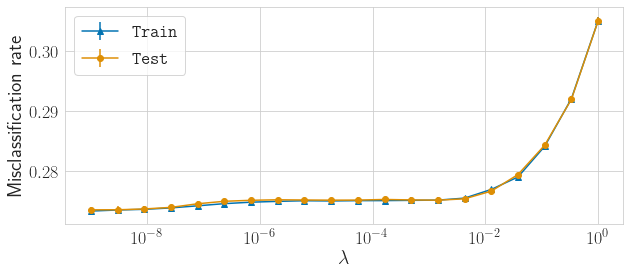

In [101]:
fig = cross_validation_visualization(lambdas, 1-acc_train, 1-acc_test)

avg_acc_test = np.mean(acc_test, axis=1)
lambda_opt_ridge = lambdas[np.argmax(avg_acc_test)]

print('Maximum test accuracy {} with lambda {}'.format(np.max(avg_acc_test), lambda_opt_ridge))

fig.savefig('../report/ridge_crossval.pdf', bbox_inches='tight')

In [102]:
# Run training
w_ridge, loss_ridge = ridge_regression(y_train, fx_train, lambda_opt_ridge)
print(f'Training loss: {loss_ridge}')

acc = eval_model(y_train, fx_train, w_ridge)
print(f'Training accuracy: {acc}')

acc_ridge = eval_model(y_eval, fx_eval, w_ridge)
print(f'Test accuracy: {acc_ridge}')

Training loss: 0.13933829612385162
Training accuracy: 0.7264914285714286
Test accuracy: 0.7260133333333333


##### Train LogReg

In [162]:
# Run cross-validation to find optimal step-size
gammas = np.logspace(-7, -2, 5)
k_fold = 4

max_iters = 5000
w_initial = np.ones(tx_train.shape[1])

# Hyperparameter optimisation
acc_train = np.empty((len(gammas), k_fold), float)
acc_test = np.empty((len(gammas), k_fold), float)

for g, gamma in enumerate(gammas):
    k = 0
    for train_split, test_split in k_fold_iter(y_train, tx_train, k_fold):
        # Train
        w, loss = logistic_regression_mean(train_split[1], train_split[0], w_initial, 
                                           max_iters, gamma, threshold=1e-6, verbose=False)
        
        acc_tr = eval_model(train_split[1], train_split[0], w, thresh=0.5)
        acc_train[g, k] = acc_tr

        # Test
        acc_te = eval_model(test_split[1], test_split[0], w, thresh=0.5)
        acc_test[g, k] = acc_te

        k += 1

../scripts\costs.py:49: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(z)) - y * z)
../scripts\implementation_variants.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:


KeyboardInterrupt: 

Maximum test accuracy 0.7230571428571428 with gamma 0.01


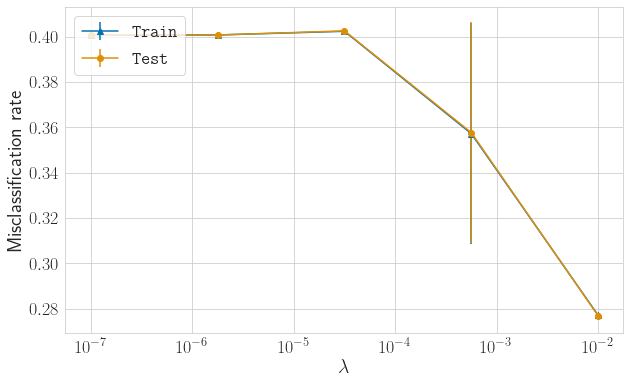

In [181]:
fig = cross_validation_visualization(gammas, 1-acc_train, 1-acc_test)
fig.savefig('../report/crossval_lr.pdf', bbox_inches='tight')
avg_acc_test = np.mean(acc_test, axis=1)
gamma_opt_lr = gammas[np.argmax(avg_acc_test)]

print('Maximum test accuracy {} with gamma {}'.format(np.max(avg_acc_test), gamma_opt_lr))

In [182]:
max_iters = 15000
w_initial = np.ones(tx_train.shape[1])

# Run gradient descent 
w_lr, loss_lr = logistic_regression_mean(y_train, tx_train, w_initial, max_iters, gamma_opt_lr, 
                                    threshold=1e-7, verbose=True)
print(f'Training loss: {loss_lr}')

acc = eval_model(y_train, tx_train, w_lr, thresh=0.5)
print(f'Training accuracy: {acc}')

acc_lr = eval_model(y_eval, tx_eval, w_lr, thresh=0.5)
print(f'Testing accuracy: {acc_lr}')

Gradient Descent (0/14999): loss=4.9399464656485925, gradient=1.1070150667360843
Gradient Descent (100/14999): loss=3.744638955603192, gradient=1.0757625234785748
Gradient Descent (200/14999): loss=2.660183871882455, gradient=0.9939685748542625
Gradient Descent (300/14999): loss=1.8358315281073783, gradient=0.8008442314450439
Gradient Descent (400/14999): loss=1.373341534216789, gradient=0.5664264578414981
Gradient Descent (500/14999): loss=1.1283284058888108, gradient=0.4414843709133819
Gradient Descent (600/14999): loss=0.9608052299096556, gradient=0.3813570647365515
Gradient Descent (700/14999): loss=0.834100959239845, gradient=0.33095041231472316
Gradient Descent (800/14999): loss=0.7403573840109454, gradient=0.2818153614972203
Gradient Descent (900/14999): loss=0.6735010928901823, gradient=0.23613902384085597
Gradient Descent (1000/14999): loss=0.6270053126903851, gradient=0.19614762202692698
Gradient Descent (1100/14999): loss=0.5950191683662266, gradient=0.16260812861450613
Grad

Gradient Descent (9700/14999): loss=0.5007412268347543, gradient=0.008094871688005649
Gradient Descent (9800/14999): loss=0.5006763996631624, gradient=0.008009585446565057
Gradient Descent (9900/14999): loss=0.5006129295013376, gradient=0.007925420622961078
Gradient Descent (10000/14999): loss=0.5005507844828353, gradient=0.007842356468902077
Gradient Descent (10100/14999): loss=0.5004899336170957, gradient=0.007760372869899766
Gradient Descent (10200/14999): loss=0.500430346759205, gradient=0.007679450313249064
Gradient Descent (10300/14999): loss=0.500371994581067, gradient=0.00759956985823273
Gradient Descent (10400/14999): loss=0.5003148485438939, gradient=0.007520713108367252
Gradient Descent (10500/14999): loss=0.5002588808719375, gradient=0.007442862185523497
Gradient Descent (10600/14999): loss=0.5002040645273809, gradient=0.007365999705770883
Gradient Descent (10700/14999): loss=0.5001503731863235, gradient=0.007290108756807825
Gradient Descent (10800/14999): loss=0.5000977812

# Compare model performance 

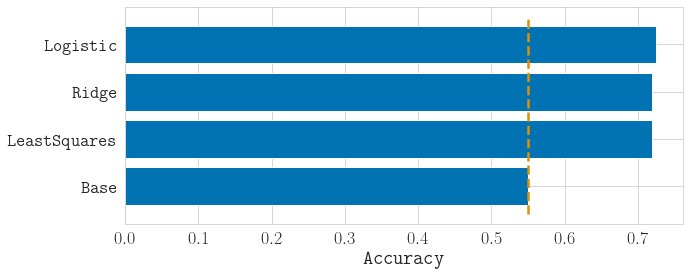

In [204]:
accuracy = [acc_baseline, acc_ls, acc_ridge, acc_lr]
labels = ['$\mathtt{Base}$', '$\mathtt{LeastSquares}$', '$\mathtt{Ridge}$',  
          '$\mathtt{Logistic}$']

fig = model_comparison_visualization(accuracy, labels, acc_baseline)
fig.savefig('../report/model_comparison_basic.pdf', bbox_inches='tight')

# Final training and test set prediction 

In [18]:
# Get all labelled records
y, x, ids = load_csv_data(path.join(DATA_PATH, 'train.csv'))

# Apply feature transform
fx = feature_transform(x)

fx=np.hstack((fx,fx**2,fx**3,fx**4,fx**5,fx**6))

# Standardise to mean and s.d.
fx, mu_x, sigma_x = standardise(fx)

# Add offset term
tx = np.c_[np.ones(len(y)), fx]

In [24]:
max_iters = 1000
w_initial = np.ones(tx.shape[1])

# Run gradient descent 
# w, loss = logistic_regression_mean(y, tx, w_initial, max_iters, gamma_opt_lr, 
#                                     threshold=1e-7, verbose=True)
w, loss = logistic_regression_mean(y, tx, BEST3, max_iters, 0.01, 
                                     threshold=1e-7, verbose=True)
print(f'Training loss: {loss}')

acc = eval_model(y, tx, w, thresh=0.5)
print(f'Training accuracy: {acc}')

Gradient Descent (0/999): loss=0.46218039101850045, gradient=0.005280689004281295
Gradient Descent (0/999): loss=0.46218039101850045, gradient=0.005280689004281295, w=[-1.11888916e+00  9.18700804e-01 -8.06746665e-01  1.61661628e-01
  6.80409983e-01  7.09141966e-01  1.62297715e+00 -1.24389053e-01
  2.70351647e-01 -5.34276777e-01  1.61377579e-01  7.88011612e-01
  1.13781183e+00 -1.96535279e-03  1.89754782e-02  6.52037309e-01
  1.26830973e-02  3.27640594e-02  4.47617033e-02  1.11561734e-02
  8.29904761e-02  5.22842236e-01  8.38970617e-01  9.83052231e-01
  9.86000496e-01  7.93159912e-01  7.84320552e-01  7.83907633e-01
  1.85481611e-01  7.83978359e-01  6.11979294e-01  1.66187163e-01
 -1.92144228e+00 -2.98370438e-01  2.81405180e-01  2.97091705e-01
  1.01350009e+00 -4.18763807e-01  1.67600883e-01  1.32899675e-01
  1.21602600e+00 -6.28752293e-01 -6.71757611e-02 -6.31536607e-03
  2.21631392e-02 -1.76894914e-01 -1.35152912e-03  3.34145225e-02
  2.09305678e-02 -3.73135315e-01  2.07329501e-01  9.1

Gradient Descent (320/999): loss=0.4620917335720097, gradient=0.005246697873693576
Gradient Descent (325/999): loss=0.46209035736042653, gradient=0.00524616904165437
Gradient Descent (330/999): loss=0.4620889814262537, gradient=0.005245640267115602
Gradient Descent (335/999): loss=0.4620876057694333, gradient=0.005245111549483507
Gradient Descent (340/999): loss=0.4620862303899077, gradient=0.005244582888163447
Gradient Descent (345/999): loss=0.46208485528761983, gradient=0.005244054282559914
Gradient Descent (350/999): loss=0.46208348046251263, gradient=0.005243525732076585
Gradient Descent (355/999): loss=0.46208210591452925, gradient=0.005242997236116369
Gradient Descent (360/999): loss=0.46208073164361374, gradient=0.0052424687940813685
Gradient Descent (365/999): loss=0.4620793576497099, gradient=0.005241940405372972
Gradient Descent (370/999): loss=0.46207798393276206, gradient=0.0052414120693918525
Gradient Descent (375/999): loss=0.4620766104927149, gradient=0.0052408837855380

Gradient Descent (815/999): loss=0.4619568264687219, gradient=0.005194528538117039
Gradient Descent (820/999): loss=0.461955477489985, gradient=0.005194002520941044
Gradient Descent (825/999): loss=0.46195412878445713, gradient=0.005193476504488613
Gradient Descent (830/999): loss=0.4619527803521106, gradient=0.005192950488293224
Gradient Descent (835/999): loss=0.4619514321929174, gradient=0.005192424471892584
Gradient Descent (840/999): loss=0.46195008430685064, gradient=0.005191898454828685
Gradient Descent (845/999): loss=0.4619487366938824, gradient=0.005191372436647906
Gradient Descent (850/999): loss=0.4619473893539864, gradient=0.0051908464169010335
Gradient Descent (855/999): loss=0.4619460422871356, gradient=0.005190320395143361
Gradient Descent (860/999): loss=0.4619446954933036, gradient=0.005189794370934777
Gradient Descent (865/999): loss=0.46194334897246403, gradient=0.005189268343839751
Gradient Descent (870/999): loss=0.4619420027245913, gradient=0.005188742313427485
G

In [23]:
BEST="-1.11888630e+00  9.18700397e-01 -8.06744857e-01  1.61650668e-01 6.80399550e-01  7.09129411e-01  1.62296601e+00 -1.24388014e-01 2.70350036e-01 -5.34271459e-01  1.61380488e-01  7.88011688e-01 1.13781269e+00 -1.96523525e-03  1.89756352e-02  6.52032397e-01 1.26831318e-02  3.27641585e-02  4.47582783e-02  1.11562600e-02 8.29890085e-02  5.22842281e-01  8.38972452e-01  9.83052339e-01 9.86000590e-01  7.93159113e-01  7.84320726e-01  7.83907830e-01 1.85480618e-01  7.83978544e-01  6.11984587e-01  1.66186864e-01 -1.92142442e+00 -2.98361316e-01  2.81400873e-01  2.97098463e-01 1.01349729e+00 -4.18756865e-01  1.67597682e-01  1.32900944e-01 1.21602581e+00 -6.28745879e-01 -6.71760773e-02 -6.31525086e-03 2.21686920e-02 -1.76894843e-01 -1.35141722e-03  3.34224084e-02 2.09305110e-02 -3.73130671e-01  2.07329452e-01  9.11922200e-01 1.01586332e+00  1.01578802e+00  1.21369357e+00  1.21602932e+00 1.21602131e+00 -3.18536578e-01  7.83978544e-01  7.89975637e-01 4.13936089e-01 -7.39025988e-01  6.00168602e-01 -1.22441845e-01 -3.05020392e-01  1.00261569e+00 -1.45524313e-01  4.56959101e-02 5.17188218e-02  7.83978549e-01 -1.82313014e-01 -2.22896491e-02 -1.81481632e-02 -1.09050941e-01 -3.11169883e-02 -3.36305898e-02 8.39033536e-01 -2.20810545e-02 -1.07547172e-01  1.93715521e-02 9.40847892e-01  9.84218370e-01  9.84218380e-01  7.81406897e-01 7.83978548e-01  7.83978544e-01  7.38541854e-03  7.83978544e-01 8.71577354e-01  1.01029620e-03  2.81422327e-02  9.31399562e-01 1.25589034e-01 -4.45680888e-01  1.00346851e+00  1.34520896e-01 -8.40923907e-02  2.15405292e-02  1.21602146e+00  2.54590125e-01 -7.73004989e-02 -2.48301701e-02 -5.58388360e-02 -6.62134333e-02 -2.30691691e-02  9.77559206e-01 -1.49364566e-02  1.44696386e-01 -9.40609372e-02  9.95549148e-01  1.01578163e+00  1.01578163e+00 1.21423940e+00  1.21602146e+00  1.21602146e+00  6.11043940e-02 7.83978544e-01  9.34616065e-01 -1.78008163e-01  1.86423878e-01 9.89582843e-01  4.00065420e-01 -3.51273945e-01  1.00410835e+00 1.22221633e-01 -2.53881460e-02 -8.06934324e-02  7.83978544e-01 3.13756143e-01  2.60057964e-02  2.97317393e-03 -2.56552871e-02 1.37590946e-02  6.69103547e-03  9.98836204e-01  9.96652818e-03 1.12284024e-01 -1.61681605e-01  9.72005765e-01  9.84218372e-01 9.84218372e-01  7.82819257e-01  7.83978544e-01  7.83978544e-01 -5.80939836e-02  7.83978544e-01  9.36710126e-01 -1.54446331e-01 2.09730112e-01  1.00064240e+00  6.15041088e-01 -1.71478309e-01 1.00421975e+00 -1.17244367e-03  8.84377931e-02 -3.82153254e-02 1.21602146e+00  3.02083341e-01  3.30977847e-02  2.43931058e-02 -6.56491305e-03  4.69119062e-02  2.08322210e-02  1.00286335e+00 -1.00859543e-02 -2.50223159e-02 -2.02009154e-01  1.00622525e+00 1.01578163e+00  1.01578163e+00  1.21526771e+00  1.21602146e+00 1.21602146e+00 -1.54135820e-01  7.83978544e-01"
BEST2=BEST.split()
BEST3=np.array([])
for i in BEST2:
    BEST3=np.append(BEST3,float(i))
BEST3

array([-1.11888630e+00,  9.18700397e-01, -8.06744857e-01,  1.61650668e-01,
        6.80399550e-01,  7.09129411e-01,  1.62296601e+00, -1.24388014e-01,
        2.70350036e-01, -5.34271459e-01,  1.61380488e-01,  7.88011688e-01,
        1.13781269e+00, -1.96523525e-03,  1.89756352e-02,  6.52032397e-01,
        1.26831318e-02,  3.27641585e-02,  4.47582783e-02,  1.11562600e-02,
        8.29890085e-02,  5.22842281e-01,  8.38972452e-01,  9.83052339e-01,
        9.86000590e-01,  7.93159113e-01,  7.84320726e-01,  7.83907830e-01,
        1.85480618e-01,  7.83978544e-01,  6.11984587e-01,  1.66186864e-01,
       -1.92142442e+00, -2.98361316e-01,  2.81400873e-01,  2.97098463e-01,
        1.01349729e+00, -4.18756865e-01,  1.67597682e-01,  1.32900944e-01,
        1.21602581e+00, -6.28745879e-01, -6.71760773e-02, -6.31525086e-03,
        2.21686920e-02, -1.76894843e-01, -1.35141722e-03,  3.34224084e-02,
        2.09305110e-02, -3.73130671e-01,  2.07329452e-01,  9.11922200e-01,
        1.01586332e+00,  

In [25]:
# Load test data
y_test, x_test, ids_test = load_csv_data(path.join(DATA_PATH, 'test.csv'))
fx_test = feature_transform(x_test)
fx_test.shape

(568238, 29)

In [26]:
fx_test=np.hstack((fx_test,fx_test**2,fx_test**3,fx_test**4,fx_test**5,fx_test**6))

# # Standardise to mean and s.d. of training data
fx_test = standardise_to_fixed(fx_test, mu_x, sigma_x)

# # Add offset term
tx_test = np.c_[np.ones(fx_test.shape[0]), fx_test]

In [27]:
# Get predictions on test set
y_pred = predict_labels(w, tx_test, thresh=0.5)
create_csv_submission(ids_test, y_pred, '../data/final_submission.csv')